## New York Times Best Sellers List

In [1]:
import os

import pandas as pd

import seaborn as sns
sns.set_context("talk")

from seaborn import plt
%matplotlib inline

In [6]:
def get_data(csv_name, directory='processed'):
    '''Returns df of csv; defaults to processed data directory'''
    path = os.path.join(os.pardir, 'data', directory, csv_name)
    return pd.read_csv(path, encoding='utf-8')

## The data

* Scraped from Wikipedia & Goodreads
* Weekly list from 1942-2016

In [27]:
authors = get_data('authors.csv')
books = get_data('books.csv')

In [28]:
list(authors.columns)

['a_id',
 'a_fans_count',
 'a_works_count',
 'gender',
 'hometown',
 'a_avg_rating',
 'a_ratings_count',
 'a_text_reviews_count',
 'author',
 'a_wks_on_list',
 'a_books_on_list']

In [29]:
list(books.columns)

['b_id',
 'gr_title',
 'nyt_title',
 'b_count',
 'pub_yr',
 'b_avg_rating',
 'b_ratings_count',
 'b_txt_rev_count',
 'publisher',
 'b_rating_5_count',
 'b_rating_4_count',
 'b_rating_3_count',
 'b_rating_2_count',
 'b_rating_1_count',
 'b_wks_on_list',
 'decade',
 'a_id']

### What are you curious about?

If you were given this dataset, what would you do first? What questions do you have?

## EDA

### Tables

Top 10 authors with highest number of weeks on the NYT list (could be multiple books)

In [30]:
authors.sort_values('a_wks_on_list', ascending=False)[['author', 'a_wks_on_list']].head(10)

,author,a_wks_on_list
67,James A. Michener,200.0
126,Stephen King,144.0
128,John Grisham,139.0
92,James Patterson,102.0
226,Danielle Steel,94.0
236,Herman Wouk,91.0
153,Robert Ludlum,81.0
238,John le Carré,77.0
101,Dan Brown,75.0
127,Tom Clancy,74.0


Top 10 books with highest number of weeks on the NYT list

In [31]:
books.sort_values('b_wks_on_list', ascending=False)[['nyt_title', 'b_wks_on_list']].head(10)

,nyt_title,b_wks_on_list
325,The Da Vinci Code,59
254,Hawaii,49
496,The Caine Mutiny,48
661,The Robe,46
472,Love Story,41
247,The Source,40
678,The Bridges of Madison County,38
551,Jonathan Livingston Seagull,38
391,Trinity,36
84,The Spy Who Came in from the Cold,34


In [101]:
def top_ten(df, label_col, value_col, num=10):
    '''Returns dataframe with 10 highest values in value_col'''
    return df.sort_values(value_col, ascending=False)[[label_col, value_col]].head(num)

In [102]:
top_ten(authors, 'author', 'a_wks_on_list')

,author,a_wks_on_list
67,James A. Michener,200.0
126,Stephen King,144.0
128,John Grisham,139.0
92,James Patterson,102.0
226,Danielle Steel,94.0
236,Herman Wouk,91.0
153,Robert Ludlum,81.0
238,John le Carré,77.0
101,Dan Brown,75.0
127,Tom Clancy,74.0


In [90]:
top_ten(books, 'nyt_title', 'b_wks_on_list')

,nyt_title,b_wks_on_list
325,The Da Vinci Code,59
254,Hawaii,49
496,The Caine Mutiny,48
661,The Robe,46
472,Love Story,41
247,The Source,40
678,The Bridges of Madison County,38
551,Jonathan Livingston Seagull,38
391,Trinity,36
84,The Spy Who Came in from the Cold,34


In [ ]:
# this isn't going to work
top_ten(books.groupby('decade').count(), 'decade', 'nyt_title')

In [96]:
# how should we fix it?
top_ten(books.groupby('decade').count(), 'decade', 'nyt_title')

,decade,nyt_title
6,2000s,217
7,2010s,194
5,1990s,100
4,1980s,78
3,1970s,45
0,1940s,44
1,1950s,33
2,1960s,31


In [518]:
def top_ten(df, column, index=True, num=10):
    '''Returns series indexed by df.index and 10 highest values of column'''
    if index != True:
        df = df.set_index(index)
    return df.sort_values(column, ascending=False)[column].head(num)

In [519]:
top_ten(books.groupby('decade').count(), 'nyt_title')

decade
2000s    217
2010s    194
1990s    100
1980s     78
1970s     45
1940s     44
1950s     33
1960s     31
Name: nyt_title, dtype: int64

Let's make this function accessible to our whole repo by moving it to a .py file.

In [37]:
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [38]:
from src.visualization import visualize as v

In [40]:
v.top_ten(books.groupby('publisher').mean(), 'b_avg_rating')

publisher
DAW Books                 4.570
Open Road Media           4.530
Scholastic                4.520
Roc                       4.495
Amy Einhorn Books         4.450
Arthur A. Levine Books    4.430
Crown                     4.390
Scholastic Inc.           4.360
Amereon Limited           4.340
Piatkus                   4.290
Name: b_avg_rating, dtype: float64

In [41]:
v.top_ten(books.groupby('publisher').count(), 'nyt_title')

publisher
Unknown                     147
Little Brown & Co            48
Berkley                      43
Bantam                       33
G.P. Putnam's                29
Grand Central Publishing     28
Harper Collins               19
Random House                 18
Warner                       17
Pocket                       16
Name: nyt_title, dtype: int64

In [42]:
v.top_ten(authors, 'a_works_count', 'author')

author
Agatha Christie        1905
Stephen King           1260
Neil Gaiman            1062
George R.R. Martin      744
Nora Roberts            652
W. Somerset Maugham     560
Ernest Hemingway        543
James Patterson         498
Umberto Eco             483
Louis L'Amour           465
Name: a_works_count, dtype: int64

### Bar charts

Number of books by decade

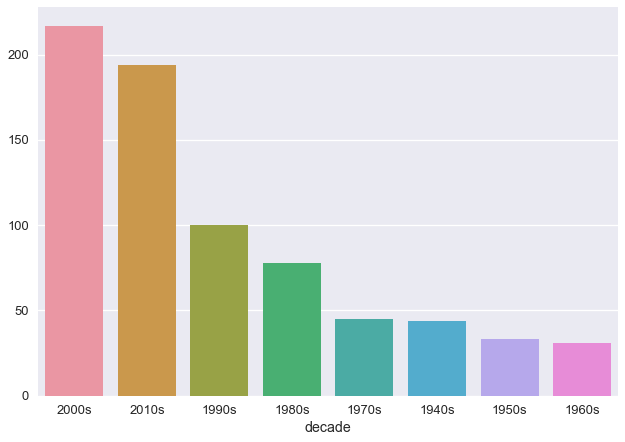

In [107]:
decades = v.top_ten(books.groupby('decade').count(), 'nyt_title')
sns.barplot(x=decades.index, y=decades.values);

Top ten authors by number of works

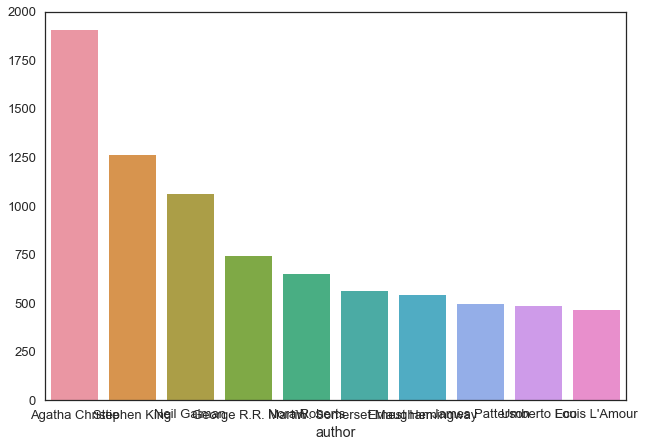

In [333]:
# series
top_ten_author_works = v.top_ten(authors, 'a_works_count', 'author')
ax = sns.barplot(x=top_ten_author_works.index, y=top_ten_author_works.values)

# rotate long labels
#plt.xticks(rotation=45)

# align labels with bars
#plt.xticks(ha='right');

# or pass kwargs to set_xticklabels
#ax.set_xticklabels(labels=top_ten_author_works.index, rotation=45, ha='right');

Weeks spent on list by gender

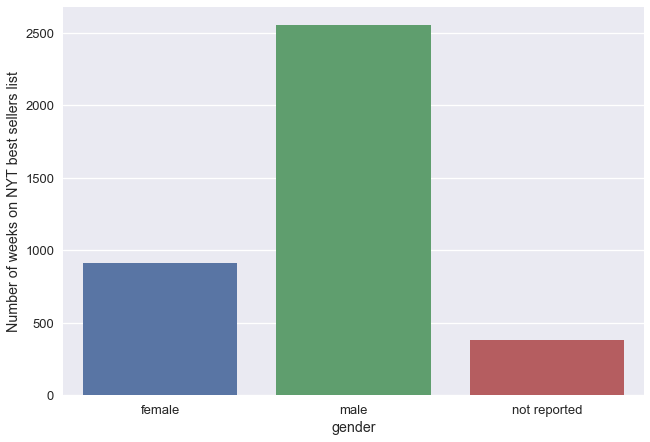

In [109]:
# df
wks_by_gender = authors.groupby('gender', as_index=False).sum()[['gender', 'a_wks_on_list']]
ax = sns.barplot(x='gender', y='a_wks_on_list', data=wks_by_gender)

# label y-axis
ax.set(ylabel='Number of weeks on NYT best sellers list');

### Presentation worthy

[Remove to improve (the data-ink ratio) by Darkhouse Analytics](http://www.darkhorseanalytics.com/blog/data-looks-better-naked)
* Remove backgrounds
* Remove redundant labels
* Remove borders
* Reduce colors
* Remove special effects
* Remove bolding
* Lighten labels
* Lighten or remove lines
* Add direct labels

Number of authors by gender

In [524]:
authors_by_gender

male            129
female           78
not reported     34
Name: gender, dtype: int64

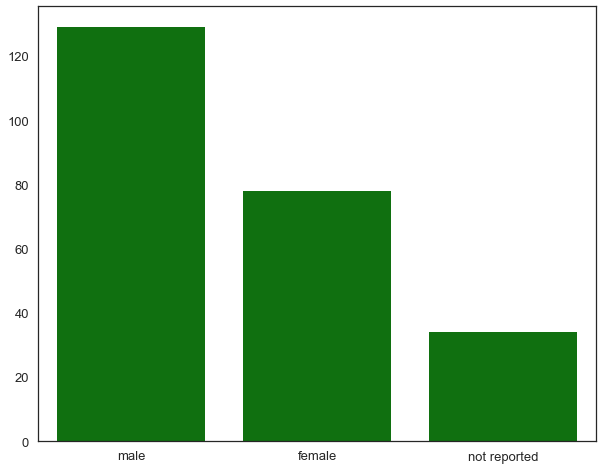

In [196]:
fig, ax = plt.subplots(figsize=(10,8)) # note: need a figure object to show plot again in subsequent cells
authors_by_gender = authors['gender'].value_counts()

# reduce colors
ax = sns.barplot(x=authors_by_gender.index, y=authors_by_gender.values, color='green', ax=ax);

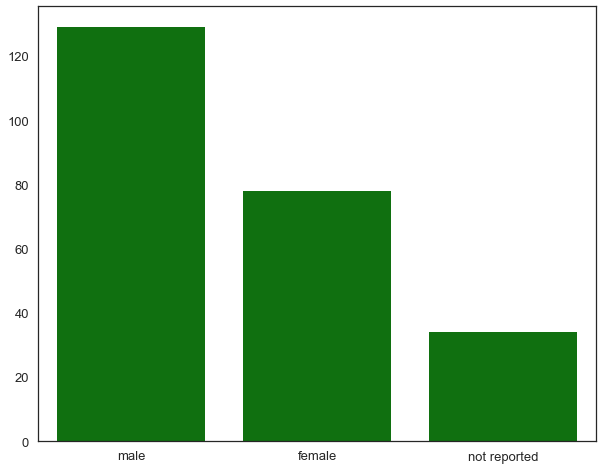

In [197]:
# remove backgrounds
sns.set_style('white')
fig

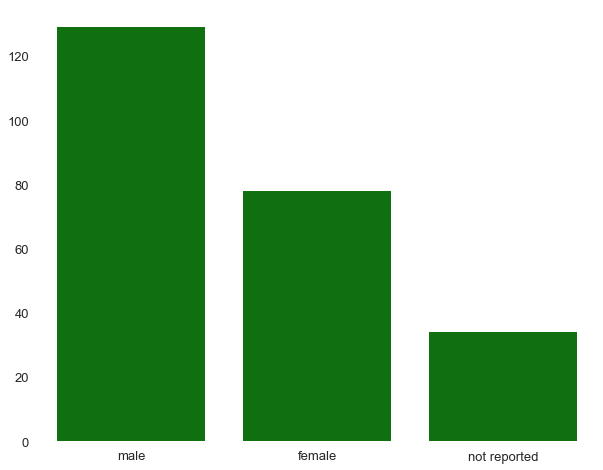

In [198]:
# remove borders
ax.set_frame_on(False)
fig

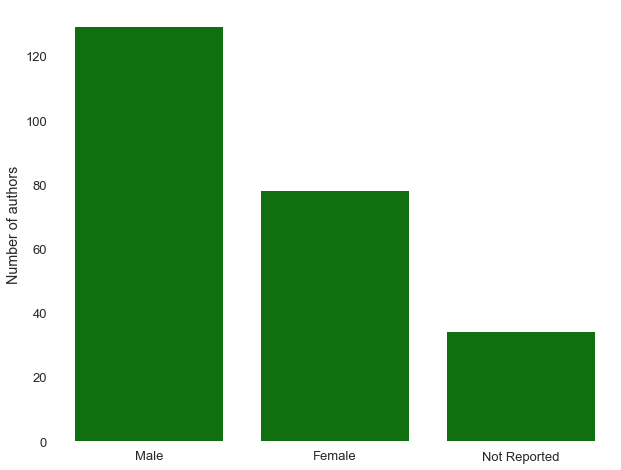

In [200]:
# add/format axes labels
ax.set_ylabel('Number of authors')
ax.set_xlabel('')
ax.set_xticklabels([label.title() for label in authors_by_gender.index])
fig

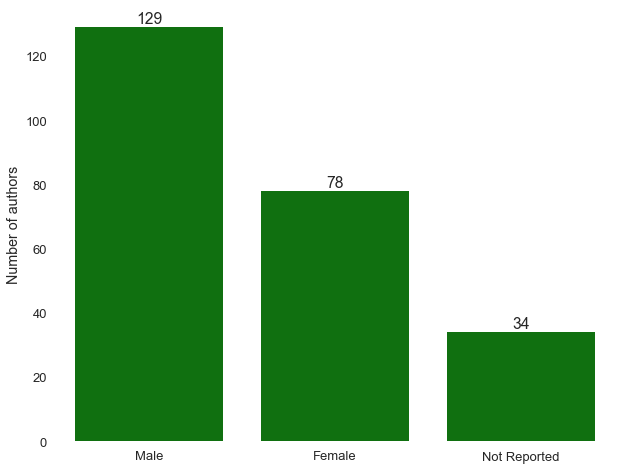

In [201]:
# add direct labels - label each bar with y value
labels = authors_by_gender.values
y_margin = max(labels) * 0.01

for bar, label in zip(ax.patches, labels):
    #x location of label
    x = bar.get_x()
    bar_width = bar.get_width()
    center = x + bar_width/2.0

    #y location of label
    bar_height = bar.get_height()
    
    ax.text(x=center, y=bar_height + y_margin, s=label, ha='center')    

fig

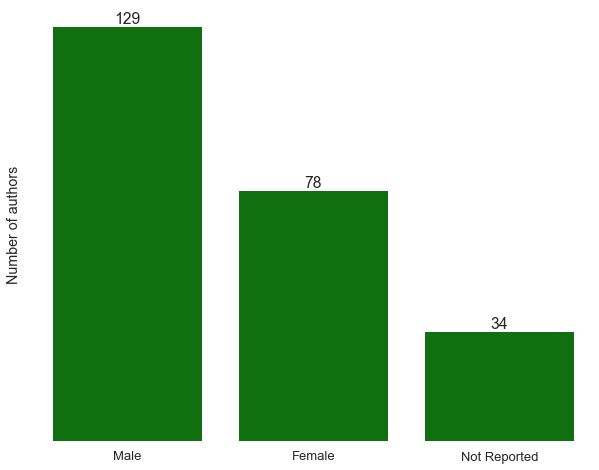

In [202]:
# remove redundant labels
ax.set_yticklabels([])
fig

Let's break this up into reusable functions

In [322]:
def create_empty_fig(xlabel='', ylabel=''):
    '''Returns empty Tufte-style fig, ax objects'''
    # create figures and axes objects to modify
    # fig controls figure-level settings (across group of subplots)
    # ax controls axis-level settings (across each subplot)
    fig, ax = plt.subplots(figsize=(10,8))
    
    # remove square outline
    ax.set_frame_on(False)
    
    return fig, ax

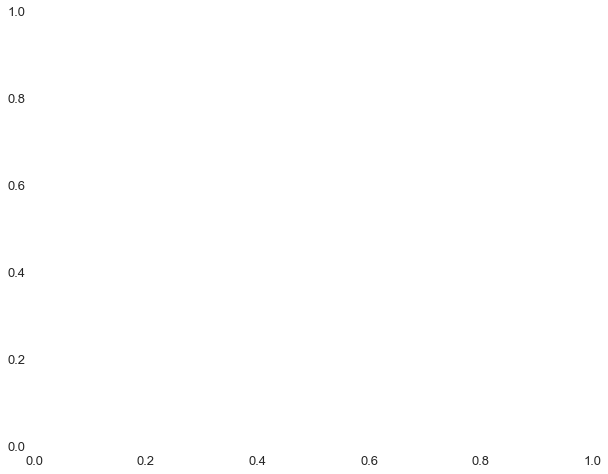

In [368]:
fig, ax = create_empty_fig()

In [369]:
def set_axes_labels(ax, xlabel='', ylabel=''):
    '''Adds axes labels'''
    # add labels for axes
    ax.set(xlabel=xlabel, ylabel=ylabel)
    return ax

In [482]:
def format_xticks(data, ax, xticks=True, xticksrotate=False):
    '''Formats xtick labels to title case if True, removes xtick labels if False'''
    if (xticks == True and xticksrotate == False):
        ax.set_xticklabels([label.title() for label in data.index])
        
    elif (xticks == True and xticksrotate == True):
        ax.set_xticklabels([label.title() for label in data.index], rotation=45, ha='right')
    
    elif (xticks == False):
        ax.set_xticklabels([])
    
    return ax

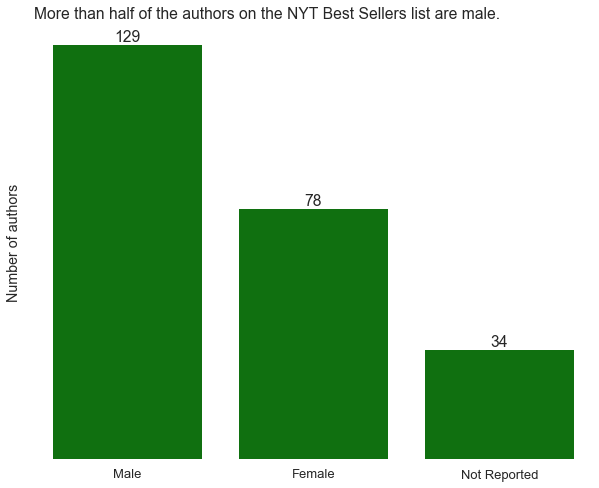

In [483]:
# note: data is a series
sns.barplot(x=authors_by_gender.index, y=authors_by_gender.values, color="green", ax=ax)
ax = set_axes_labels(ax, ylabel='Number of authors')
ax = format_xticks(authors_by_gender, ax)
fig

In [484]:
# add direct labels
def add_bar_labels(data, ax):
    '''Removes y-axis label and adds direct labels to tops of bars of sns barplot'''
    # remove y axis tick labels
    ax.set_yticklabels([])
    
    # label each bar with y value
    labels = data.values 
    y_margin = max(labels) * 0.01
    for bar, label in zip(ax.patches, labels):
        #x location of label
        x = bar.get_x()
        bar_width = bar.get_width()
        center = x + bar_width/2.0

        #y location of label
        bar_height = bar.get_height()

        ax.text(x=center, y=bar_height + y_margin, s=label, ha='center')
    
    return ax

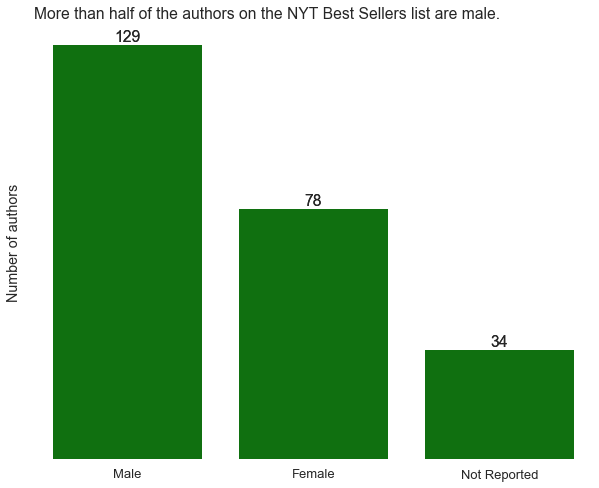

In [485]:
ax = add_bar_labels(authors_by_gender, ax)
fig

How would you interpret the graph above? What would you want the audience to take away?

### Meaning

Drive your message home with your visualization: highlight the bar with the highest value and add a meaningful title.

In [486]:
# dataset is number of authors by gender
data = authors['gender'].value_counts()

# color palette
highlight = 'green'
standard = 'grey'

colors = [standard if (value < max(data.values)) else highlight for value in data.values]
list(zip(data, colors))

[(129, 'green'), (78, 'grey'), (34, 'grey')]

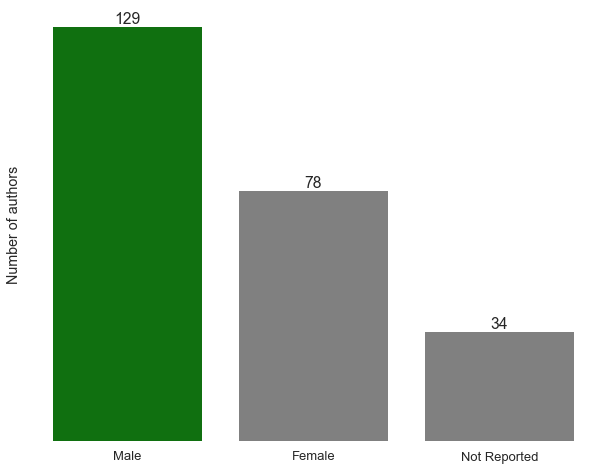

In [500]:
# create the plot
fig, ax = create_empty_fig()
sns.barplot(x=data.index, y=data.values, palette=colors, ax=ax)

ax = set_axes_labels(ax, ylabel='Number of authors')
ax = format_xticks(authors_by_gender, ax)
ax = add_bar_labels(authors_by_gender, ax)

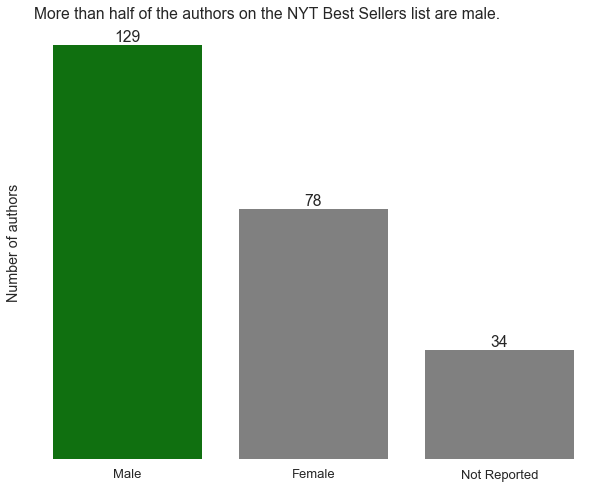

In [488]:
# add a meaningful title
ax.set_title('More than half of the authors on the NYT Best Sellers list are male.', loc='left')
fig

Let's break this up into reusable functions.

In [489]:
def highlight_max(data, highlight, standard):
    '''Return list of colors, with index of maximum value in data set to highlight color'''
    return [highlight if (x == max(data.values)) else standard for x in data.values]

In [550]:
def bar_chart(data, highlight='grey', standard='grey', xlabel='', ylabel='', title='', xticksrotate=False):
    '''
    Creates Tufte-style bar chart 
    Set highlight to string of color to highlight highest value bar
    Note: data is a series with labeled indices
    '''
    # create empty fig, ax
    fig, ax = create_empty_fig()

    # draw plot bar
    colors = highlight_max(data, highlight, standard)
    ax = sns.barplot(x=data.index, y=data.values, palette=colors, ax=ax)
    
    ax = set_axes_labels(ax, xlabel=xlabel, ylabel=ylabel)
    
    # format xtick labels    
    ax = format_xticks(data, ax, xticksrotate=xticksrotate)

    # add labels on top of bars
    ax = add_bar_labels(data, ax)
    
    # add a meaningful title
    ax.set_title(title, loc='left')
    
    return fig, ax

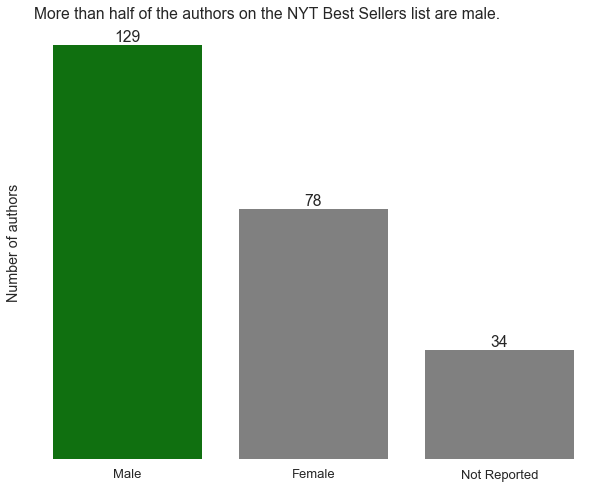

In [551]:
# create the plot
ylabel='Number of authors'
title = 'More than half of the authors on the NYT Best Sellers list are male.'
fig, ax = bar_chart(authors_by_gender, highlight='green', ylabel=ylabel, title=title);

gender
female           910.0
male            2553.0
not reported     379.0
Name: a_wks_on_list, dtype: float64


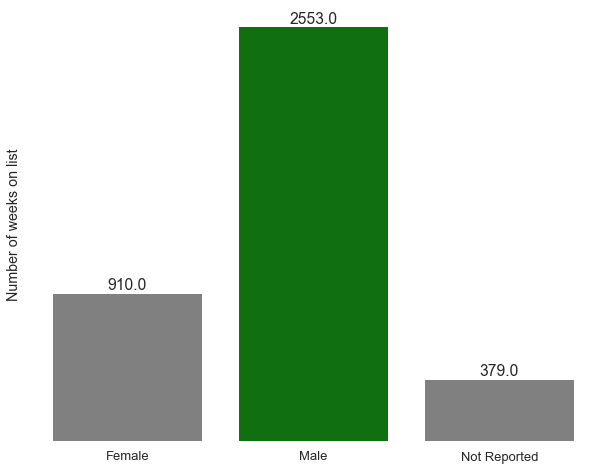

In [553]:
# dataset is number of weeks on nyt gender of author
wks_by_gender = authors.groupby('gender').sum()['a_wks_on_list']
print(wks_by_gender)

bar_chart(wks_by_gender, highlight='green', ylabel='Number of weeks on list');

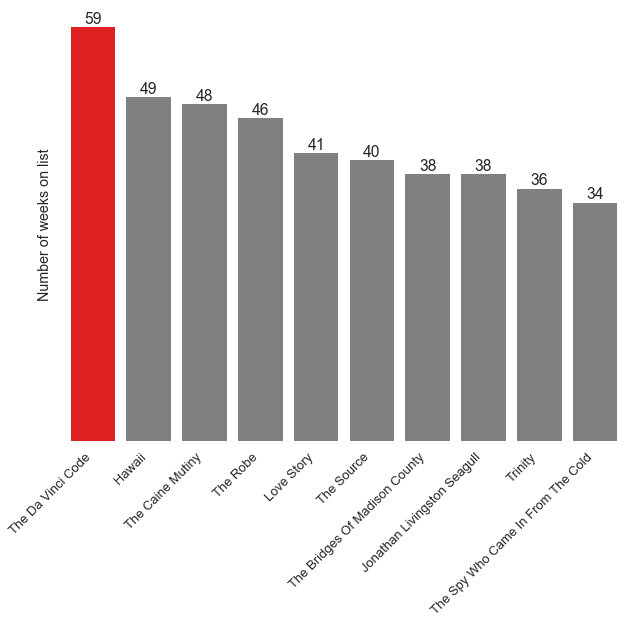

In [554]:
books_by_wks = top_ten(books, 'b_wks_on_list', index='nyt_title')
bar_chart(books_by_wks, ylabel='Number of weeks on list', xticksrotate=True, highlight='red');

### Line chart

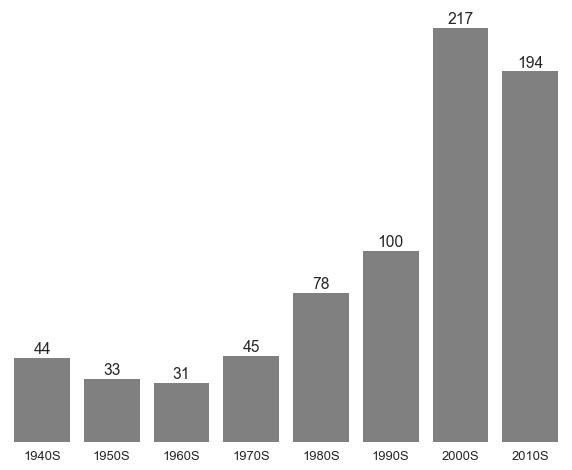

In [555]:
decades = v.top_ten(books.groupby('decade').count(), 'nyt_title').sort_index()
bar_chart(decades);

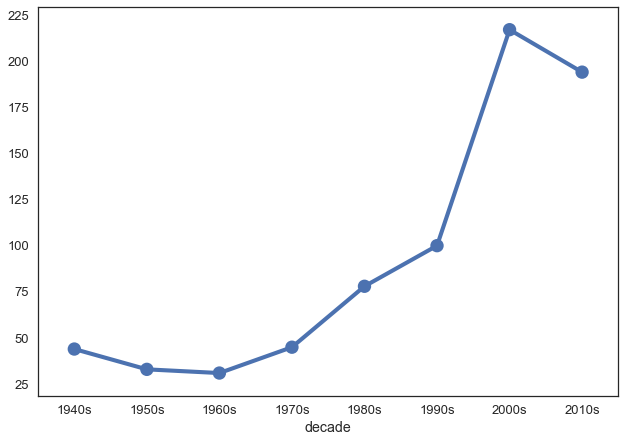

In [556]:
sns.pointplot(decades.index, decades.values);

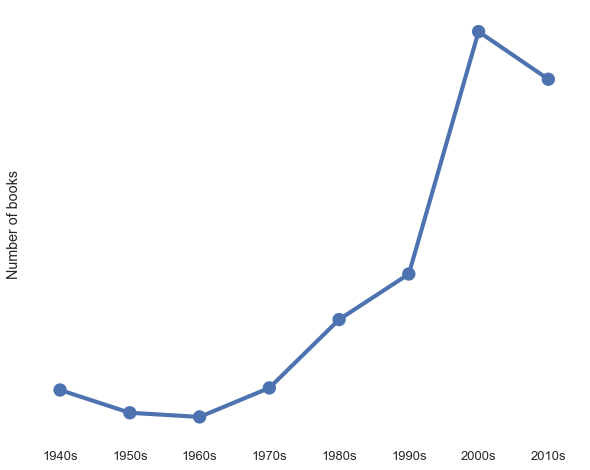

In [557]:
fig, ax = create_empty_fig()
sns.pointplot(decades.index, decades.values, ax=ax)
set_axes_labels(ax, xlabel='', ylabel='Number of books')
ax.set_yticks([]);